In [179]:
#initialise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as DateFormatter
import seaborn as sns
from plotnine import *
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import datetime
from itertools import repeat

# libraries for two-way anova
import statsmodels.api as sm
from statsmodels.formula.api import ols

# library for one-way anova
from scipy.stats import f_oneway

# libraries for posthoc tests
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

# libraries for tests of normality
import math
import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import kstest

# library for test of equality of variance
from scipy.stats import levene

In [180]:
#import jobs datasets

recruit = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Monthly Recruitment:Resignation Rates by Industry and Occupational Group, Quarterly/average-monthly-recruitment-resignation-rate-by-industry-and-occupational-group-level-3.csv',
                        header=0)

vacancy = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-by-industry-and-occupational-group-level3.csv',
                        header=0)

vacancyr = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-rate-by-industry-and-occupational-group-level3.csv',
                        header=0)

compensation = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Compensation Of Employees By Industry At Current Prices, Annual/compensation-of-employees-by-industry-at-current-prices-annual.csv',
                            header=0,
                            dtype={'year':str,
                                    'level_1':str,
                                    'level_2':str,
                                    'value':float})
compensation['compensation_million']=compensation['value']
compensation['industry2']=compensation['level_2']
compensation = compensation[['year','industry2','compensation_million']]
compensation = compensation[compensation['industry2']=='Information & Communications'].reset_index(drop=True)
compensation['industry2'] = compensation['industry2'].replace('Information & Communications', 'information and communications')

weekly_ot = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Weekly Paid Overtime Hours Worked Per Employee By Industry, Quarterly/average-weekly-paid-overtime-hours-worked-per-employee-by-industry-level-3.csv',
                        header=0)

weekly_ot[['year', 'quarter']] = weekly_ot['quarter'].str.split(pat='-', n=1, expand=True) # split the quarter column into year and quarter columns
weekly_ot.insert(0, 'year', weekly_ot.pop('year')) # move year column to the front
weekly_ot['overtime_paid_hours'] = weekly_ot['overtime_paid_hours'].replace('-',0)
weekly_ot = weekly_ot.astype({'year':str,
                                'quarter':str,
                                'industry1':str,
                                'industry2':str,
                                'industry3':str,
                                'overtime_paid_hours':float})
weekly_ot = weekly_ot[weekly_ot['industry2']=='information and communications']
weekly_ot['industry3'] = weekly_ot['industry3'].replace(['telecommunications','broadcasting and publishing'], 'telecommunications, broadcasting and publishing')
weekly_ot = weekly_ot.reset_index(drop=True)

weekly_hours = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Weekly Paid Hours Worked Per Employee By Industry, Quarterly/average-weekly-paid-hours-worked-per-employee-by-industry-level-3.csv',
                            header=0)

weekly_hours[['year', 'quarter']] = weekly_hours['quarter'].str.split(pat='-', n=1, expand=True) # split the quarter column into year and quarter columns
weekly_hours.insert(0, 'year', weekly_hours.pop('year')) # move year column to the front
weekly_hours['total_paid_hours'] = weekly_hours['total_paid_hours'].replace('-',0)
weekly_hours = weekly_hours.astype({'year':str,
                                'quarter':str,
                                'industry1':str,
                                'industry2':str,
                                'industry3':str,
                                'total_paid_hours':float})
weekly_hours = weekly_hours[weekly_hours['industry2']=='information and communications']
weekly_hours['industry3'] = weekly_hours['industry3'].replace(['telecommunications','broadcasting and publishing'], 'telecommunications, broadcasting and publishing')
weekly_hours = weekly_hours.reset_index(drop=True)

weekly_hours = weekly_ot.merge(weekly_hours,on=['year','quarter','industry1','industry2','industry3'])[['year','quarter','industry1','industry2','industry3','total_paid_hours','overtime_paid_hours']]
weekly_hours['base_hours'] = weekly_hours['total_paid_hours']-weekly_hours['overtime_paid_hours']

retrenchment_ind = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Incidence of Retrenchment by Industry and Occupational Group, Annual/incidence-of-retrenchment-by-industry-level2.csv',
                                header=0)

retrenchment_ind['incidence_of_retrenchment'] = retrenchment_ind['incidence_of_retrenchment'].replace('-',0)
retrenchment_ind = retrenchment_ind.astype({'year':str,
                                            'industry1':str,
                                            'industry2':str,
                                            'incidence_of_retrenchment':float})
retrenchment_ind = retrenchment_ind[retrenchment_ind['industry2']=='information and communications']
retrenchment_ind = retrenchment_ind.reset_index(drop=True)

# join recruit, vacancy, vacancyr dataframes and filter for information and comms industry
jobs = vacancy.merge(vacancyr,on=['quarter','industry1','industry2','industry3','occupation1'])[['quarter','industry1','industry2','industry3','occupation1','job_vacancy','job_vacancy_rate']].merge(recruit,on=['quarter','industry1','industry2','industry3','occupation1'])[['quarter','industry1','industry2','industry3','occupation1','job_vacancy','job_vacancy_rate','recruitment_rate','resignation_rate']]

jobs = jobs[jobs['industry2']=='information and communications'].reset_index(drop=True)
jobs[['year', 'quarter']] = jobs['quarter'].str.split(pat='-', n=1, expand=True) # split the quarter column into year and quarter columns
jobs.insert(0, 'year', jobs.pop('year')) # move year column to the front
jobs['industry3'] = jobs['industry3'].replace(['telecommunications','broadcasting and publishing'], 'telecommunications, broadcasting and publishing') # unified industry3 values
jobs = jobs[jobs['occupation1']=='total']
jobs = jobs.merge(compensation,on=['year','industry2'])[['year','quarter','industry1','industry2','industry3','occupation1','job_vacancy','job_vacancy_rate','recruitment_rate','resignation_rate','compensation_million']]\
        .merge(weekly_hours,on=['year','quarter','industry1','industry2','industry3'])[['year','quarter','industry1','industry2','industry3','occupation1','job_vacancy','job_vacancy_rate','recruitment_rate','resignation_rate','compensation_million','total_paid_hours','overtime_paid_hours','base_hours']]\
        .merge(retrenchment_ind,on=['year','industry1','industry2'])[['year','quarter','industry1','industry2','industry3','occupation1','job_vacancy','job_vacancy_rate','recruitment_rate','resignation_rate','compensation_million','total_paid_hours','overtime_paid_hours','base_hours','incidence_of_retrenchment']]
jobs = jobs[['year','quarter','industry1','industry2','industry3','job_vacancy','job_vacancy_rate','recruitment_rate','resignation_rate','compensation_million','total_paid_hours','overtime_paid_hours','base_hours','incidence_of_retrenchment']]

# change the datatypes for all columns in jobs dataset and replace '-' with 0
jobs = jobs.replace('-',0)

convert_dict = {'year':str,
                'quarter':str,
                'job_vacancy':int,
                'job_vacancy_rate':float,
                'recruitment_rate':float,
                'resignation_rate':float
                }

jobs = jobs.astype(convert_dict)

# drop the rows where numeric data is '0'
jobs = jobs[jobs['year'] != 0][jobs['job_vacancy'] != 0][jobs['job_vacancy_rate'] != 0][jobs['recruitment_rate'] != 0][jobs['resignation_rate'] != 0][jobs['compensation_million'] != 0][jobs['total_paid_hours'] != 0][jobs['overtime_paid_hours'] != 0][jobs['base_hours'] != 0].reset_index(drop=True)

#view first 10 rows of dataset
jobs.head(10)

print(f"The jobs dataset is a combination of:\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Monthly Recruitment:Resignation Rates by Industry and Occupational Group, Quarterly/average-monthly-recruitment-resignation-rate-by-industry-and-occupational-group-level-3.csv',\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-by-industry-and-occupational-group-level3.csv',\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-rate-by-industry-and-occupational-group-level3.csv',\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Compensation Of Employees By Industry At Current Prices, Annual/compensation-of-employees-by-industry-at-current-prices-annual.csv',\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Weekly Paid Overtime Hours Worked Per Employee By Industry, Quarterly/average-weekly-paid-overtime-hours-worked-per-employee-by-industry-level-3.csv',\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Weekly Paid Hours Worked Per Employee By Industry, Quarterly/average-weekly-paid-hours-worked-per-employee-by-industry-level-3.csv' and\n'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Incidence of Retrenchment by Industry and Occupational Group, Annual/incidence-of-retrenchment-by-industry-level2.csv'.")
print()
print(f"The datasets were merged and then filtered for jobs in the information and communication (ICT) industry. The year and quarter columns were created using string split from the original quarter column.")
print()
print(f"This is the shape of the dataset\n{jobs.shape}")
print()
print(f"This is the index of the dataset\n{jobs.index}")
print()
print(f"These are the columns in the dataset\n{jobs.columns}")
print()
print(f"The total number of non-NA values in this dataset is:\n{jobs.count()}")
print()
print(f"A summary of this dataset is shown below:")
print(jobs.info())
print()
print(f"A descriptive statistical summary of this dataset is shown below:\n{jobs[['job_vacancy','job_vacancy_rate','recruitment_rate','resignation_rate']].describe()}")

jobs

The jobs dataset is a combination of:
'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Average Monthly Recruitment:Resignation Rates by Industry and Occupational Group, Quarterly/average-monthly-recruitment-resignation-rate-by-industry-and-occupational-group-level-3.csv',
'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-by-industry-and-occupational-group-level3.csv',
'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Job Vacancy By Industry and Occupational Group, Quarterly/job-vacancy-rate-by-industry-and-occupational-group-level3.csv',
'/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Compensation Of Employees By Industry At Current Prices, Annual/compensation-of-employees-by-industry-at-current-prices-annual.csv',
'/User

/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_5808/2088529600.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,year,quarter,industry1,industry2,industry3,job_vacancy,job_vacancy_rate,recruitment_rate,resignation_rate,compensation_million,total_paid_hours,overtime_paid_hours,base_hours,incidence_of_retrenchment
0,2000,Q1,services,information and communications,"telecommunications, broadcasting and publishing",500,6.1,2.7,3.2,2534.6,43.2,0.9,42.3,12.1
1,2000,Q1,services,information and communications,"telecommunications, broadcasting and publishing",500,6.1,2.7,3.2,2534.6,43.4,0.9,42.5,12.1
2,2000,Q1,services,information and communications,"telecommunications, broadcasting and publishing",500,6.1,2.7,3.2,2534.6,43.2,1.2,42.0,12.1
3,2000,Q1,services,information and communications,"telecommunications, broadcasting and publishing",500,6.1,2.7,3.2,2534.6,43.4,1.2,42.2,12.1
4,2000,Q1,services,information and communications,"telecommunications, broadcasting and publishing",700,6.5,2.5,2.0,2534.6,43.2,0.9,42.3,12.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,2018,Q2,services,information and communications,it and other information services,3000,5.7,2.8,2.0,11583.1,41.6,0.4,41.2,13.1
307,2018,Q3,services,information and communications,"telecommunications, broadcasting and publishing",1000,3.4,1.8,1.1,11583.1,41.5,0.4,41.1,13.1
308,2018,Q3,services,information and communications,it and other information services,3300,5.4,2.5,1.7,11583.1,41.7,0.4,41.3,13.1
309,2018,Q4,services,information and communications,"telecommunications, broadcasting and publishing",600,2.2,1.4,0.9,11583.1,41.9,0.3,41.6,13.1


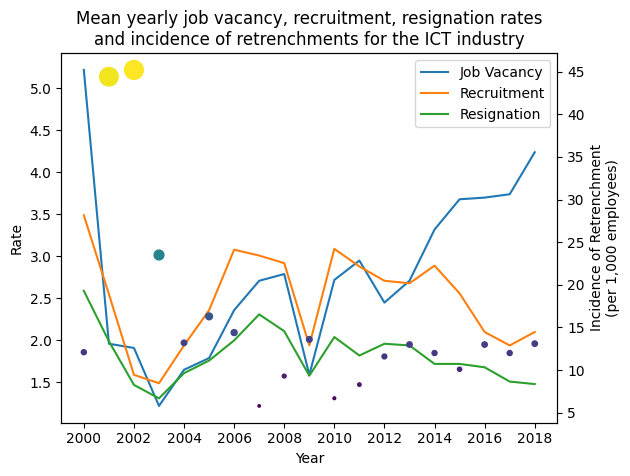

In [274]:
jobs.head(10)

jobs_mean = jobs[['year','job_vacancy_rate','recruitment_rate','resignation_rate','incidence_of_retrenchment']].groupby('year', as_index=False).mean().round(2)
jobs_mean['year'] = pd.to_datetime(jobs_mean['year'], format='%Y')

jobs_mean_melt = pd.melt(jobs_mean[['year','job_vacancy_rate','recruitment_rate','resignation_rate','incidence_of_retrenchment']], 
                            id_vars=['year'],
                            value_vars=['job_vacancy_rate','recruitment_rate','resignation_rate','incidence_of_retrenchment'],
                            value_name='rate')
jobs_mean_melt['variable'] = jobs_mean_melt['variable'].replace(['job_vacancy_rate','recruitment_rate','resignation_rate','incidence_of_retrenchment'], ['Job Vacancy','Recruitment','Resignation','Incidence of Retrenchment'])

fig,ax1 = plt.subplots()

sns.lineplot(ax=ax1,data=jobs_mean_melt[jobs_mean_melt['variable'] != 'Incidence of Retrenchment'],x='year',y='rate',hue='variable')
ax1.set_ylabel('Rate')
ax1.set_xlabel('Year')
ax1.set_title('Mean yearly job vacancy, recruitment, resignation rates\nand incidence of retrenchments for the ICT industry')
ax1.legend(title='')

ax2 = ax1.twinx()
colors = jobs_mean_melt[jobs_mean_melt['variable'] == 'Incidence of Retrenchment']['rate']
area = (0.3 * jobs_mean_melt[jobs_mean_melt['variable'] == 'Incidence of Retrenchment']['rate'])**2
ax2.scatter(jobs_mean_melt[jobs_mean_melt['variable'] == 'Incidence of Retrenchment']['year'],jobs_mean_melt[jobs_mean_melt['variable'] == 'Incidence of Retrenchment']['rate'],s=area,c=colors)
ax2.set(ylabel='Incidence of Retrenchment\n(per 1,000 employees)')

plt.show()

# ggplot(jobs_mean_melt,aes('year','rate', group='variable', color='variable'))+\
#     geom_line()+\
#     scale_y_continuous(breaks=range(0,10,1))+\
#     scale_x_date(date_breaks='2 year',date_labels='%Y')+\
#     labs(x="Year",y="Rate",title="Mean Yearly Job Vacancy, Recruitment and Resignation Rates for the ICT industy")+\
#     scale_color_discrete(name="Jobs")

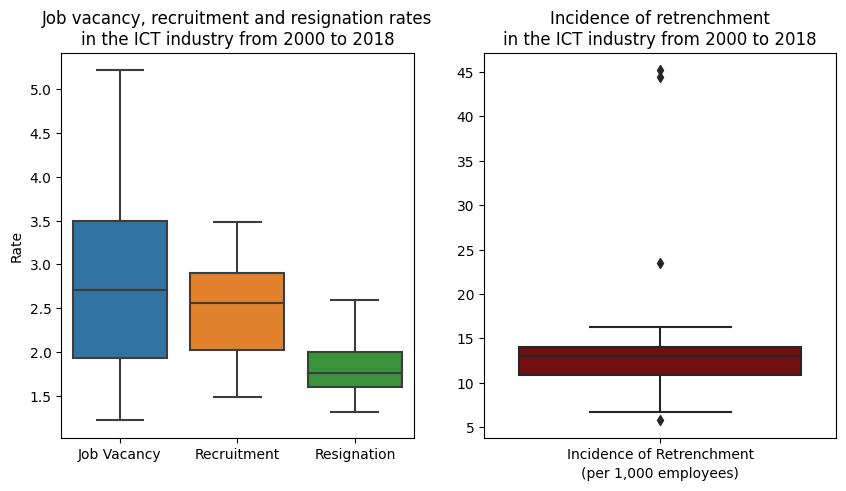

In [277]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

sns.boxplot(ax=ax[0],x=jobs_mean_melt[jobs_mean_melt['variable'] != 'Incidence of Retrenchment']['variable'],y=jobs_mean_melt['rate'])
ax[0].set(title='Job vacancy, recruitment and resignation rates\nin the ICT industry from 2000 to 2018',
        ylabel='Rate',
        xlabel='')

sns.boxplot(ax=ax[1],x=jobs_mean_melt[jobs_mean_melt['variable'] == 'Incidence of Retrenchment']['variable'],y=jobs_mean_melt['rate'],color='maroon')
ax[1].set(title='Incidence of retrenchment\nin the ICT industry from 2000 to 2018',
        ylabel='',
        xlabel='(per 1,000 employees)')

plt.show()

/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_5808/2582755977.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


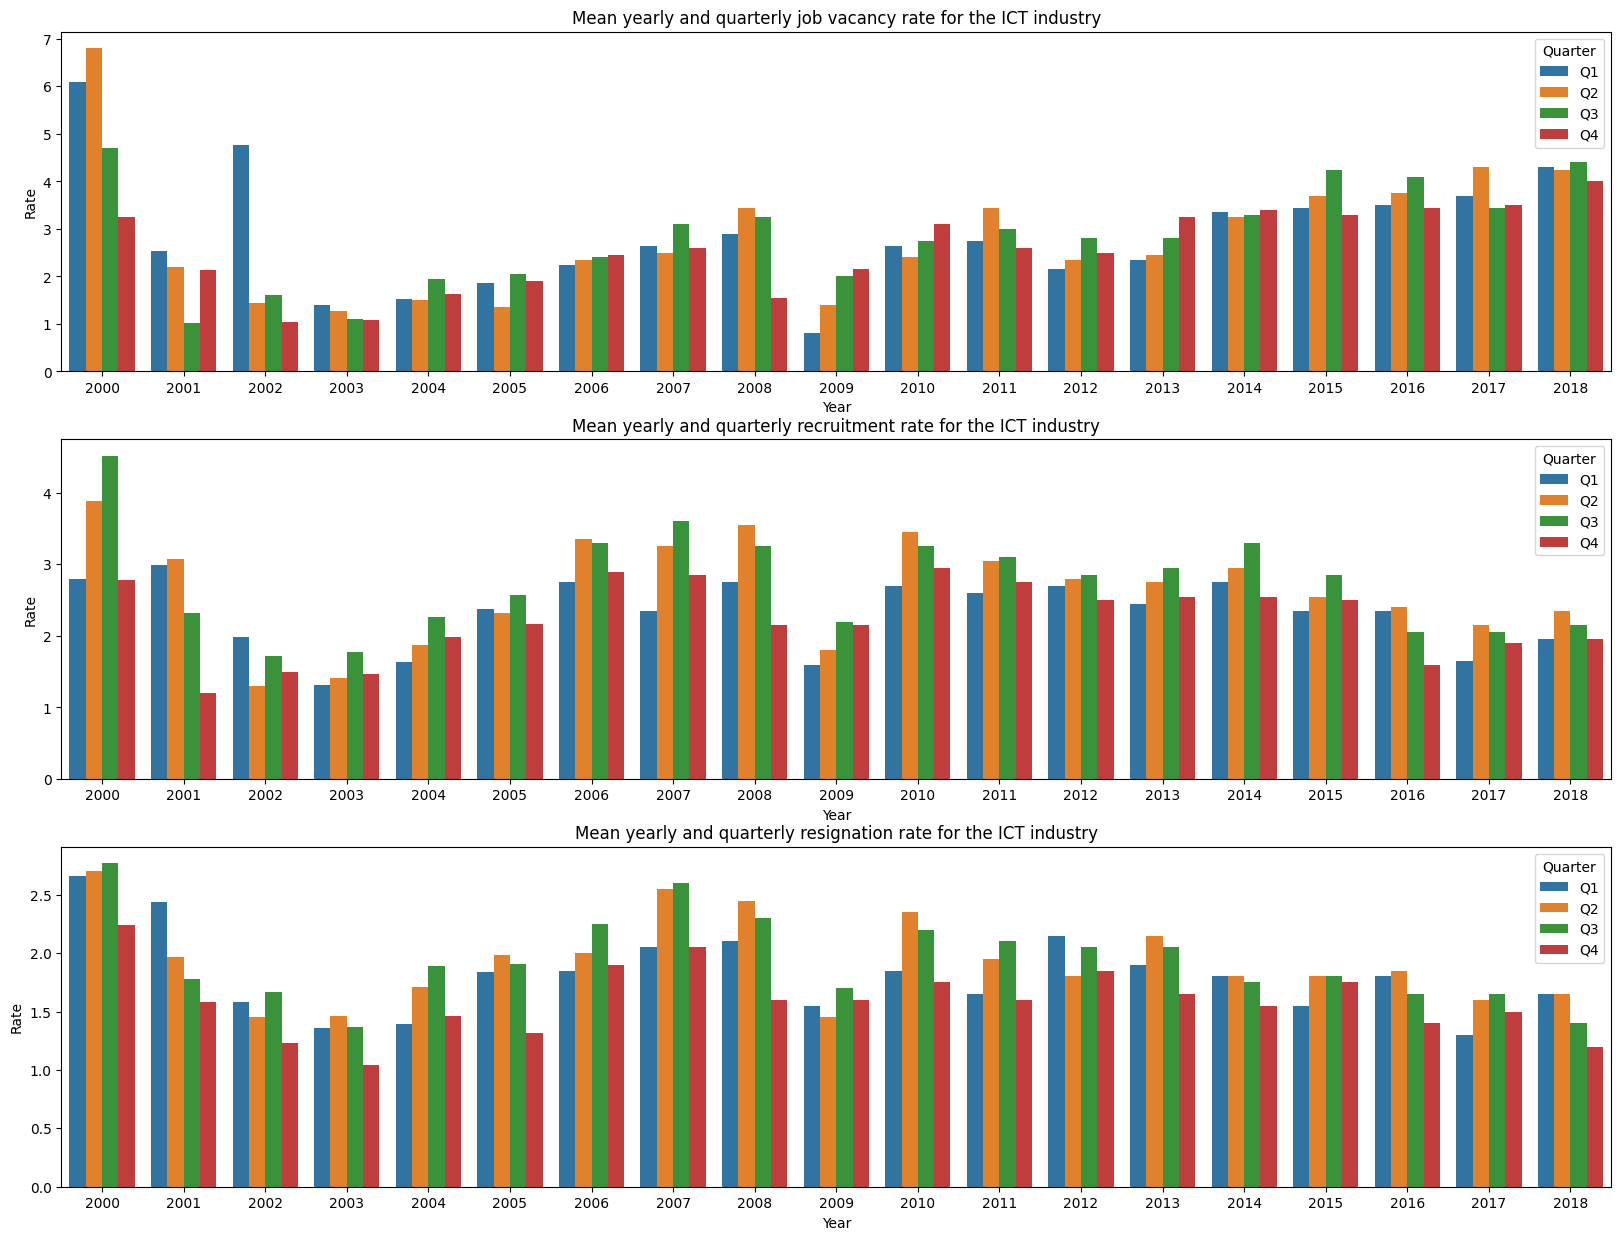

In [246]:
jobs.head(10)

jobsmeanq = jobs.drop(['job_vacancy'],axis=1).groupby(['year','quarter'], as_index=False).mean().round(2)

jobsmeanq_melt = pd.melt(jobsmeanq, 
                            id_vars=['year','quarter'],
                            value_vars=['job_vacancy_rate','recruitment_rate','resignation_rate'],
                            value_name='rate')
jobsmeanq_melt['variable'] = jobsmeanq_melt['variable'].replace(['job_vacancy_rate','recruitment_rate','resignation_rate'], ['Job Vacancy','Recruitment','Resignation'])

fig, axes = plt.subplots(3,1, figsize=(20,15))

sns.barplot(ax=axes[0],data=jobsmeanq_melt[jobsmeanq_melt['variable']=='Job Vacancy'],x='year',y='rate',hue='quarter')
axes[0].set(ylabel='Rate',
        xlabel='Year',
        title='Mean yearly and quarterly job vacancy rate for the ICT industry')
axes[0].legend(title='Quarter')

sns.barplot(ax=axes[1],data=jobsmeanq_melt[jobsmeanq_melt['variable']=='Recruitment'],x='year',y='rate',hue='quarter')
axes[1].set(ylabel='Rate',
        xlabel='Year',
        title='Mean yearly and quarterly recruitment rate for the ICT industry')
axes[1].legend(title='Quarter')

sns.barplot(ax=axes[2],data=jobsmeanq_melt[jobsmeanq_melt['variable']=='Resignation'],x='year',y='rate',hue='quarter')
axes[2].set(ylabel='Rate',
        xlabel='Year',
        title='Mean yearly and quarterly resignation rate for the ICT industry')
axes[2].legend(title='Quarter')

plt.show()

/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_5808/410458479.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


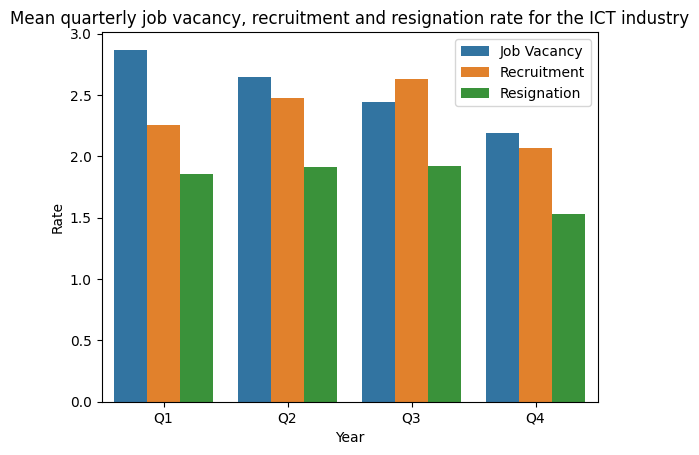

In [184]:
jobsmeanq = jobs.drop(['job_vacancy'],axis=1).groupby('quarter', as_index=False).mean().round(2)

jobsmeanq_melt = pd.melt(jobsmeanq, 
                            id_vars=['quarter'],
                            value_vars=['job_vacancy_rate','recruitment_rate','resignation_rate'],
                            value_name='rate')
jobsmeanq_melt['variable'] = jobsmeanq_melt['variable'].replace(['job_vacancy_rate','recruitment_rate','resignation_rate'], ['Job Vacancy','Recruitment','Resignation'])

p = sns.barplot(jobsmeanq_melt,x='quarter',y='rate',hue='variable')
p.set(ylabel='Rate',
        xlabel='Year',
        title='Mean quarterly job vacancy, recruitment and resignation rate for the ICT industry')
p.legend(title='')

plt.show()

KstestResult(statistic=0.7743017847127813, pvalue=6.751975248770744e-197, statistic_location=1.1, statistic_sign=-1)


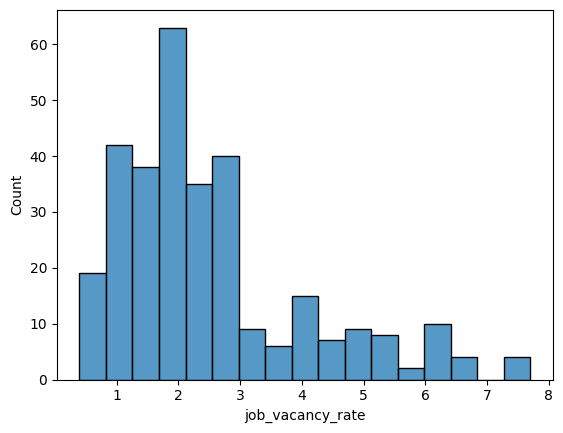

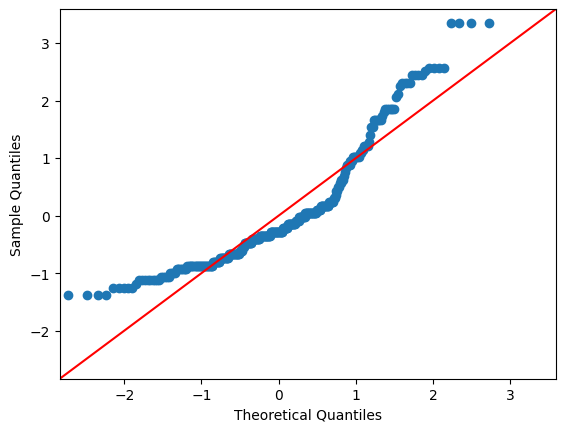

In [185]:
sns.histplot(jobs, x='job_vacancy_rate')

print(kstest(jobs['job_vacancy_rate'],'norm')) # sample size more than 50

std_vacancy = (jobs['job_vacancy_rate']-jobs['job_vacancy_rate'].mean())/jobs['job_vacancy_rate'].std()

fig = sm.qqplot(std_vacancy,line='45')

#job vacancy rate data is not normal based on Q-Q plot!!

KstestResult(statistic=0.8413447460685429, pvalue=5.887382456576929e-248, statistic_location=1.0, statistic_sign=-1)


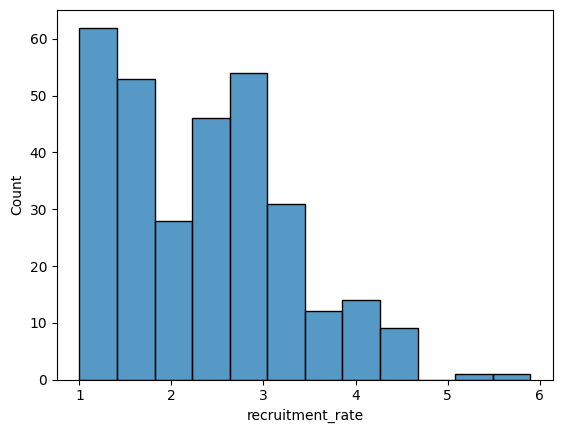

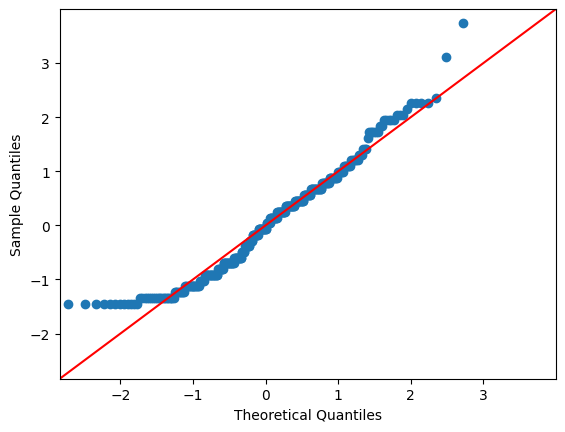

In [186]:
sns.histplot(jobs, x='recruitment_rate')

print(kstest(jobs['recruitment_rate'],'norm')) # sample size more than 50

std_recruitment = (jobs['recruitment_rate']-jobs['recruitment_rate'].mean())/jobs['recruitment_rate'].std()

fig = sm.qqplot(std_recruitment,line='45')

# recruitment rate data is normal!!

KstestResult(statistic=0.8124058393161313, pvalue=4.456716321222126e-224, statistic_location=1.0, statistic_sign=-1)


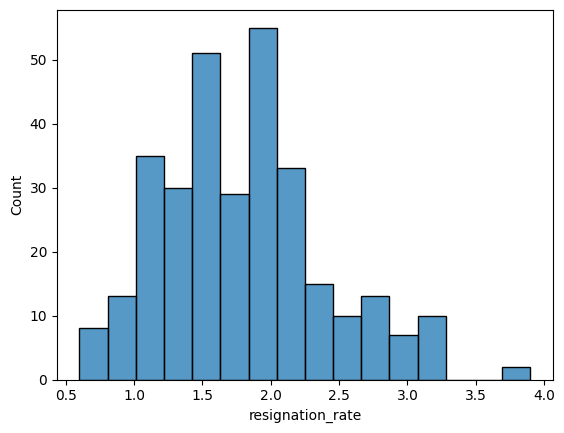

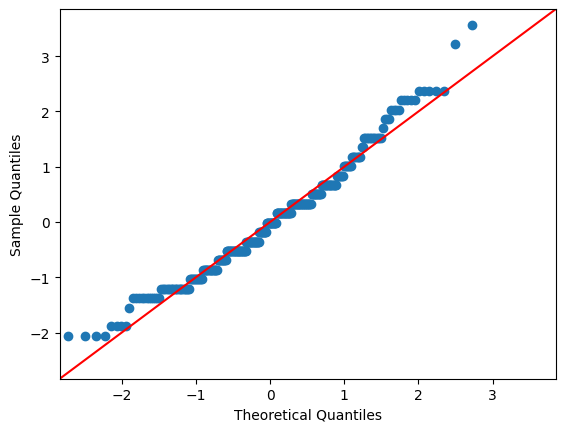

In [187]:
sns.histplot(jobs, x='resignation_rate')

print(kstest(jobs['resignation_rate'],'norm')) # sample size more than 50

std_resignation = (jobs['resignation_rate']-jobs['resignation_rate'].mean())/jobs['resignation_rate'].std()

fig = sm.qqplot(std_resignation,line='45')

# resignation rate data is normal!!

In [188]:
quarter_vacancy = [jobs.loc[ids, 'job_vacancy_rate'].values for ids in jobs.groupby('quarter').groups.values()]
quarter_recruitment = [jobs.loc[ids, 'recruitment_rate'].values for ids in jobs.groupby('quarter').groups.values()]
quarter_resignation = [jobs.loc[ids, 'resignation_rate'].values for ids in jobs.groupby('quarter').groups.values()]

# non-parametric ANOVA for non-normal data
# https://scikit-posthocs.readthedocs.io/en/latest/
print('Kruskal-Wallis H test for job vacancy rates by quarter')
print(stats.kruskal(*quarter_vacancy))
print()

# parametric ANOVA using ols and lm
print('ANOVA for recruitment rates by quarter')
lm_recruit = sfa.ols('recruitment_rate ~ C(quarter)', data=jobs).fit()
print(sa.stats.anova_lm(lm_recruit))
print()
print('ANOVA for resignation rates by quarter')
lm_resign = sfa.ols('resignation_rate ~ C(quarter)', data=jobs).fit()
print(sa.stats.anova_lm(lm_resign))
print()

# test for equality of variances
print(levene(*quarter_recruitment))
print(levene(*quarter_resignation))
print()

# posthoc t-test for resignation_rate by quarter
print('Post-hoc Tukey test for recruitment rates by quarter')
print(sp.posthoc_tukey(jobs,val_col='recruitment_rate',group_col='quarter'))
print()
print('Post-hoc Tueky test for resignation rates by quarter')
print(sp.posthoc_tukey(jobs,val_col='resignation_rate',group_col='quarter'))

Kruskal-Wallis H test for job vacancy rates by quarter
KruskalResult(statistic=5.728556857420848, pvalue=0.1255898094551409)

ANOVA for recruitment rates by quarter
               df      sum_sq   mean_sq         F    PR(>F)
C(quarter)    3.0   13.916963  4.638988  5.412241  0.001219
Residual    307.0  263.138535  0.857129       NaN       NaN

ANOVA for resignation rates by quarter
               df     sum_sq   mean_sq         F    PR(>F)
C(quarter)    3.0   7.769942  2.589981  8.045005  0.000035
Residual    307.0  98.834496  0.321936       NaN       NaN

LeveneResult(statistic=3.157327865802448, pvalue=0.02505092854420344)
LeveneResult(statistic=0.6927432151190833, pvalue=0.5570696789747744)

Post-hoc Tukey test for recruitment rates by quarter
          Q1        Q2        Q3        Q4
Q1  1.000000  0.435325  0.063253  0.597334
Q2  0.435325  1.000000  0.730536  0.032213
Q3  0.063253  0.730536  1.000000  0.001279
Q4  0.597334  0.032213  0.001279  1.000000

Post-hoc Tueky test for res

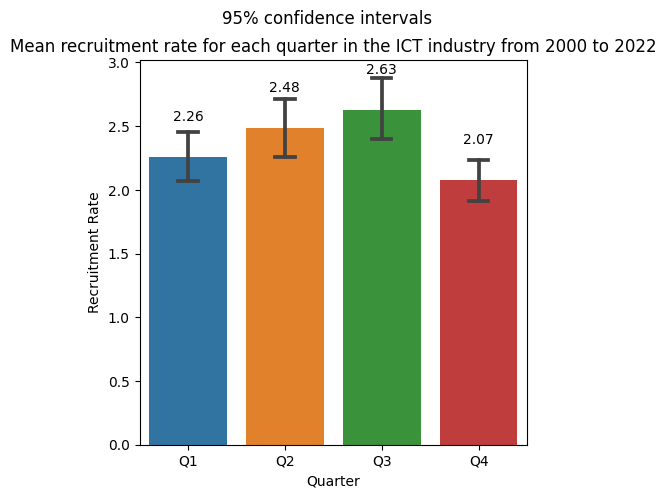

In [201]:
plt.subplots(figsize=(5,5))

s = sns.barplot(data=jobs[['quarter','recruitment_rate']],
                x='quarter',
                y='recruitment_rate',
                estimator=np.mean,
                errorbar=('ci',95),
                capsize=.2)
s.set(title='Mean recruitment rate for each quarter in the ICT industry from 2000 to 2022',
        xlabel='Quarter',
        ylabel='Recruitment Rate')
s.bar_label(s.containers[0],fmt='%.2f',padding=24)
plt.suptitle('95% confidence intervals')

plt.show()

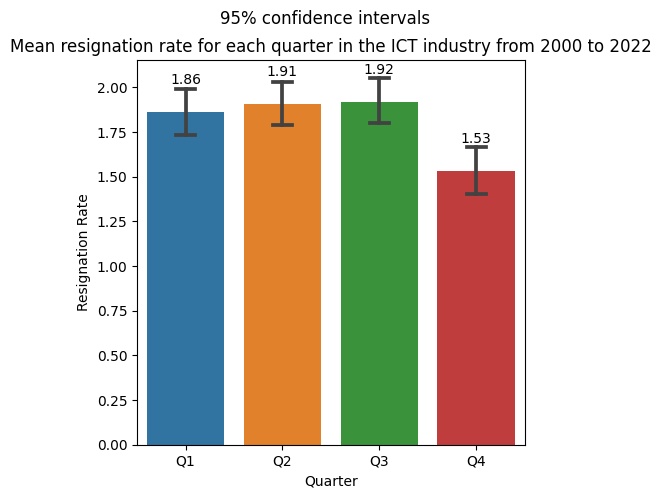

In [206]:
plt.subplots(figsize=(5,5))

s = sns.barplot(data=jobs[['quarter','resignation_rate']],
                x='quarter',
                y='resignation_rate',
                estimator=np.mean,
                errorbar=('ci',95),
                capsize=.2)
s.set(title='Mean resignation rate for each quarter in the ICT industry from 2000 to 2022',
        xlabel='Quarter',
        ylabel='Resignation Rate')
s.bar_label(s.containers[0],fmt='%.2f',padding=18)
plt.suptitle('95% confidence intervals')

plt.show()

In [191]:
# import schools datasets

poly = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Polytechnics - Intake, Enrolment, Graduates/polytechnics-intake-enrolment-and-graduates-by-course.csv',
                    header=0)

uni = pd.read_csv('/Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Universities - Intake, Enrolment, Graduates/universities-intake-enrolment-and-graduates-by-course.csv',
                    header=0)

print(f"The polytechnic dataset was successfully loaded: /Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Polytechnics - Intake, Enrolment, Graduates/polytechnics-intake-enrolment-and-graduates-by-course.csv")
print()
print(f"This is the shape of the dataset\n{poly.shape}")
print()
print(f"This is the index of the dataset\n{poly.index}")
print()
print(f"These are the columns in the dataset\n{poly.columns}")
print()
print(f"The total number of non-NA values in this dataset is:\n{poly.count()}")
print()
print(f"A summary of this dataset is shown below:")
print(poly.info())
print()
print(f"A descriptive statistical summary of this dataset is shown below:\n{poly[['intake','enrolment','graduates']].describe()}")
print()
print()
print()
print()
print(f"The university dataset was successfully loaded: /Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Universities - Intake, Enrolment, Graduates/universities-intake-enrolment-and-graduates-by-course.csv")
print()
print(f"This is the shape of the dataset\n{uni.shape}")
print()
print(f"This is the index of the dataset\n{uni.index}")
print()
print(f"These are the columns in the dataset\n{uni.columns}")
print()
print(f"The total number of non-NA values in this dataset is:\n{uni.count()}")
print()
print(f"A summary of this dataset is shown below:")
print(uni.info())
print()
print(f"A descriptive statistical summary of this dataset is shown below:\n{uni[['intake','enrolment','graduates']].describe()}")

The polytechnic dataset was successfully loaded: /Users/iylia/Library/Mobile Documents/com~apple~CloudDocs/SP/Intro to Programming for DS/CA2/Data/Polytechnics - Intake, Enrolment, Graduates/polytechnics-intake-enrolment-and-graduates-by-course.csv

This is the shape of the dataset
(408, 6)

This is the index of the dataset
RangeIndex(start=0, stop=408, step=1)

These are the columns in the dataset
Index(['year', 'sex', 'course', 'intake', 'enrolment', 'graduates'], dtype='object')

The total number of non-NA values in this dataset is:
year         408
sex          408
course       408
intake       408
enrolment    408
graduates    408
dtype: int64

A summary of this dataset is shown below:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       408 non-null    int64 
 1   sex        408 non-null    object
 2   course     408 non-null    object
 

In [192]:
poly['course'].unique()

# filter poly data for ICT industry degrees
poly_ict = poly[poly['course'].isin(['Engineering Sciences','Information Technology','Mass Communication'])].reset_index(drop=True)

uni['course'].unique()

# filter uni data for ICT industry degrees
uni_ict = uni[uni['course'].isin(['Engineering Sciences','Information Technology','Mass Communication'])].reset_index(drop=True)

# merge poly and uni datasets
poly_uni_ict = poly_ict.merge(uni_ict, on=['year','sex','course'], suffixes=('_poly','_uni'))

print(poly_uni_ict.head(10))

   year sex                  course  intake_poly  enrolment_poly  \
0  2005  MF    Engineering Sciences         7826           22462   
1  2005   F    Engineering Sciences         2097            5939   
2  2005  MF  Information Technology         4122           11607   
3  2005   F  Information Technology         1887            5065   
4  2005  MF      Mass Communication          448            1426   
5  2005   F      Mass Communication          324            1029   
6  2006  MF    Engineering Sciences         8209           23713   
7  2006   F    Engineering Sciences         2108            6197   
8  2006  MF  Information Technology         3972           11753   
9  2006   F  Information Technology         1728            5134   

   graduates_poly  intake_uni  enrolment_uni  graduates_uni  
0            6536        4028          16599           3859  
1            2005        1170           4868           1200  
2            3356         773           2356            562  
3  

In [193]:
# calculate the M numbers from MF numbers in the poly_uni_ict df

sex_idx = poly_uni_ict
sex_idx.sort_values(['year','course'],inplace=True) # sort the values as the 2019 and 2020 values had MF and F grouped together
sex_idx.set_index(['sex','year','course'],inplace=True) # set index so that calculation only done for numeric columns
sex_idx_m = pd.DataFrame(sex_idx.diff(-1).loc['MF']) # calculate difference between MF and F rows then save only MF row values as a new df
sex_idx_m['sex'] = list((repeat('M',len(sex_idx_m)))) # create a 'sex' column with 'M' values in the new df

sex_idx.reset_index(inplace=True) # reset the index for original sex_idx
sex_idx.set_index(['year','course'],inplace=True) # set index for sex_idx to match new d

# only keep the 'F' rows in ori df then append the new df with 'M' rows and then reset index and then sort values then reset index then save as poly_uni_ict
poly_uni_ict = sex_idx.loc[sex_idx['sex']=='F'].append(sex_idx_m).reset_index().sort_values(['year','course','sex'],ignore_index=True)
poly_uni_ict['sex'] = poly_uni_ict['sex'].replace(['F','M'],['Female','Male'])

/var/folders/nv/c05ywcr140z_fcwc2kx0h69m0000gn/T/ipykernel_5808/2599982041.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<function matplotlib.pyplot.show(close=None, block=None)>

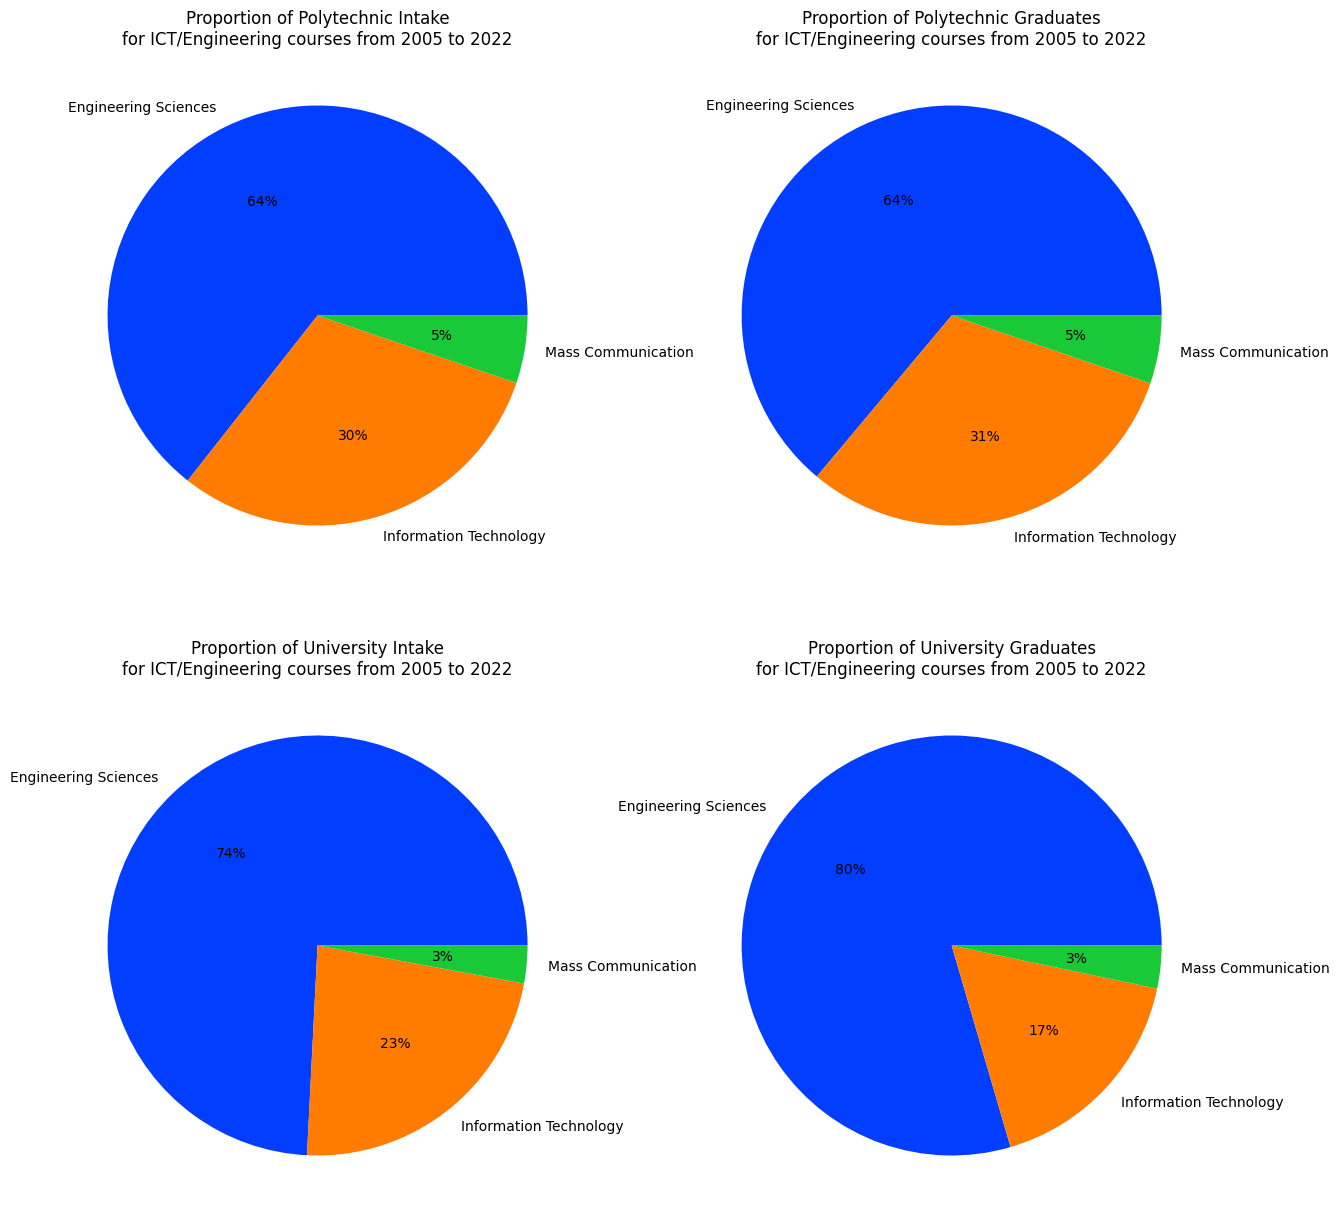

In [194]:
poly_uni_ict

totals_polyuniict = poly_uni_ict.set_index(['year','sex']).groupby('course').sum().reset_index()
totals_polyuniict

fig, ax = plt.subplots(2,2, figsize=(15,15))

palette_color = sns.color_palette('bright')

ax[0,0].pie(totals_polyuniict['intake_poly'],labels=totals_polyuniict['course'],colors=palette_color,autopct='%.0f%%')
ax[0,0].set(title='Proportion of Polytechnic Intake\nfor ICT/Engineering courses from 2005 to 2022')

ax[0,1].pie(totals_polyuniict['graduates_poly'],labels=totals_polyuniict['course'],colors=palette_color,autopct='%.0f%%')
ax[0,1].set(title='Proportion of Polytechnic Graduates\nfor ICT/Engineering courses from 2005 to 2022')

ax[1,0].pie(totals_polyuniict['intake_uni'],labels=totals_polyuniict['course'],colors=palette_color,autopct='%.0f%%')
ax[1,0].set(title='Proportion of University Intake\nfor ICT/Engineering courses from 2005 to 2022')

ax[1,1].pie(totals_polyuniict['graduates_uni'],labels=totals_polyuniict['course'],colors=palette_color,autopct='%.0f%%')
ax[1,1].set(title='Proportion of University Graduates\nfor ICT/Engineering courses from 2005 to 2022')

plt.show